In [1]:
## import packages 
## Utility tools 
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import itertools
## Models 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn import svm
from sklearn.pipeline import Pipeline

## Analysis tools 
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, make_scorer
from sklearn import model_selection
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
## Fetching data
#Connecting to database
path = "../input/"  #Insert path here
database = 'steam_data.sqlite'
conn = sqlite3.connect(database)


In [3]:

user_item_profile = pd.read_sql( \
    'select australian_user_reviews.user_id, australian_users_items.items_count as u_items_count, count(australian_user_reviews.review) as u_reviews_count, sum(australian_users_items.playtime_2weeks) as u_playtime_2weeks, sum(australian_users_items.playtime_forever) as u_playtime_forever, \
       australian_user_reviews.item_id, steam_games.metascore, steam_games.price, \
       accounting as accounting, action as action, adventure as adventure, "animation &amp; modeling" as aandm, "audio production" as audio_production, casual as casual, "design &amp; illustration" as dandi, "early access" as early_access, education as education, "free to play" as free_to_play, indie as indie, "massively multiplayer" as massively_multiplayer, "Photo Editing" as photo_editing, rpg as rpg, racing as racing, simulation as simulation, "software training" as software_training, sports as sports, strategy as strategy, utilities as utilities, "video production" as video_production, "web publishing" as web_publishing, \
       australian_user_reviews.recommend \
from australian_user_reviews \
    left join item_genres on item_genres.id = australian_user_reviews.item_id \
    left join steam_games on australian_user_reviews.item_id = steam_games.id \
    left join australian_users_items on australian_users_items.user_id=australian_user_reviews.user_id and australian_users_items.item_id=australian_user_reviews.item_id \
group by australian_user_reviews.user_id' \
    , conn)


user_item_profile.describe()

,u_items_count,u_reviews_count,u_playtime_2weeks,u_playtime_forever,metascore,price,accounting,action,adventure,aandm,...,rpg,racing,simulation,software_training,sports,strategy,utilities,video_production,web_publishing,recommend
count,11052.000000,25451.000000,11850.000000,11850.000000,16186.000000,23005.000000,21428.0,21428.000000,21428.000000,21428.000000,...,21428.000000,21428.000000,21428.000000,21428.000000,21428.000000,21428.000000,21428.000000,21428.000000,21428.000000,25451.000000
mean,141.973398,2.364740,213.778565,23233.507848,82.013036,13.085786,0.0,0.764467,0.266847,0.002427,...,0.203145,0.017780,0.148124,0.000047,0.020814,0.113683,0.000747,0.002287,0.000327,0.889474
std,235.266671,2.265684,835.219614,41249.214810,8.954822,13.846573,0.0,0.424341,0.442322,0.049203,...,0.402349,0.132156,0.355231,0.006831,0.142764,0.317433,0.027316,0.047766,0.018072,0.313551
min,1.000000,1.000000,0.000000,0.000000,24.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,1.000000,0.000000,1545.750000,78.000000,0.000000,0.0,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,90.000000,1.000000,0.000000,7368.000000,83.000000,9.990000,0.0,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,160.000000,3.000000,12.000000,28228.750000,89.000000,19.990000,0.0,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,7762.000000,38.000000,23904.000000,828020.000000,96.000000,189.960000,0.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
user_item_profile_fd = user_item_profile.fillna(0)

#user_item_profile_fd = user_item_profile.dropna()

train_data = user_item_profile_fd.drop(["user_id", "item_id"], axis=1)

train_data

,u_items_count,u_reviews_count,u_playtime_2weeks,u_playtime_forever,metascore,price,accounting,action,adventure,aandm,...,rpg,racing,simulation,software_training,sports,strategy,utilities,video_production,web_publishing,recommend
0,58.0,1,0.0,2949.0,72.0,19.99,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,2,0.0,1269.0,92.0,0.00,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,23.0,2,599.0,36320.0,83.0,14.99,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,68.0,5,0.0,31552.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,167.0,1,0.0,11889.0,81.0,29.99,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25446,0.0,1,0.0,0.0,92.0,0.00,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
25447,0.0,1,0.0,0.0,92.0,0.00,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
25448,50.0,1,0.0,3846.0,78.0,0.00,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
25449,73.0,9,0.0,86057.0,95.0,19.99,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [5]:
number_of_features = train_data.shape[1] - 1
feature_column_indices = list(range(0, number_of_features))

label_index = train_data.shape[1] - 1

features = train_data.drop(['recommend'], axis=1)

labels = train_data['recommend']

In [6]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

transformer = MaxAbsScaler().fit(features)
features_scaled = transformer.transform(features)
pd.DataFrame(features_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,25451.000000,25451.000000,25451.000000,25451.000000,25451.000000,25451.000000,25451.0,25451.000000,25451.000000,25451.000000,...,25451.0,25451.000000,25451.000000,25451.000000,25451.000000,25451.000000,25451.000000,25451.000000,25451.000000,25451.000000
mean,0.007943,0.062230,0.004164,0.013064,0.543308,0.062267,0.0,0.643629,0.224667,0.002043,...,0.0,0.171035,0.014970,0.124710,0.000039,0.017524,0.095713,0.000629,0.001925,0.000275
std,0.021934,0.059623,0.024255,0.036761,0.417739,0.072214,0.0,0.478936,0.417371,0.045156,...,0.0,0.376547,0.121435,0.330397,0.006268,0.131215,0.294203,0.025066,0.043836,0.016582
min,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.026316,0.000000,0.000000,0.791667,0.052590,0.0,1.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.010049,0.078947,0.000000,0.007194,0.875000,0.105233,0.0,1.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


[0.22676361 0.19540027 0.11918763]


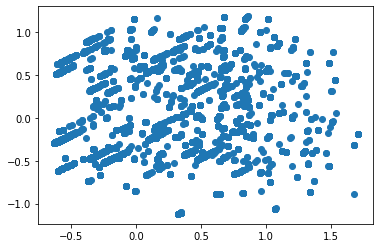

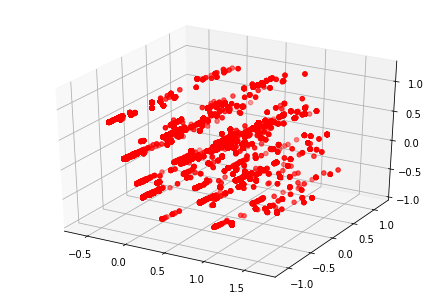

In [7]:
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


pca = PCA(n_components=3)
pca.fit(features_scaled)
print(pca.explained_variance_ratio_)

train_data_pca = pca.transform(features_scaled)

plt.plot(train_data_pca[:,0], train_data_pca[:,1], "o")

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(train_data_pca[:,0], train_data_pca[:,1], train_data_pca[:,2],c='r')

plt.show()

In [8]:
#Build models and train

#Splitting the data into Train and Test data sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size = 0.2, random_state = 42, stratify = labels)

#Initializing classifiers
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')
AB_clf = AdaBoostClassifier(n_estimators = 200, random_state = 2)
MLP_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
KNN_clf = KNeighborsClassifier()
LOG_clf = linear_model.LogisticRegression(multi_class = "ovr", solver = "sag", class_weight = 'balanced', max_iter=100)
GNB_clf = GaussianNB()
SVM_clf = svm.SVC(gamma='scale', probability=True)
clfs = [RF_clf, AB_clf, MLP_clf, KNN_clf, LOG_clf, GNB_clf, SVM_clf]


#Specficying scorer and parameters for grid search
feature_len = features.shape[1]
scorer = make_scorer(accuracy_score)
parameters_RF = {'clf__max_features': ['auto', 'log2'], 
                 'pca__n_components': [5, 10, 15]}
parameters_AB = {'clf__learning_rate': np.linspace(0.5, 2, 5), 
                 'pca__n_components': [5, 10, 15]}
parameters_MLP = {'pca__n_components': [5, 10, 15]}
parameters_KNN = {'clf__n_neighbors': [3, 5, 10], 
                  'pca__n_components': [5, 10, 15]}
parameters_LOG = {'pca__n_components': [5, 10, 15]}
parameters_GNB = {'pca__n_components': [5, 10, 15]}
parameters_SVM = {'pca__n_components': [5, 10, 15]}

parameters = {clfs[0]: parameters_RF,
              clfs[1]: parameters_AB,
              clfs[2]: parameters_MLP,
              clfs[3]: parameters_KNN,
              clfs[4]: parameters_LOG,
              clfs[5]: parameters_GNB,
              clfs[6]: parameters_SVM}


#Initializing PCA
pca = PCA()

#Creating cross validation data splits
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)

#Initialize result storage
clfs_return = []
dm_reduce_return = []
train_scores = []
test_scores = []

#Loop through classifiers
for clf in clfs:

    estimators = [('pca', pca), ('clf', clf)]
    pipeline = Pipeline(estimators)
    
    print("Training a {} with {}...".format(clf.__class__.__name__, pca.__class__.__name__))
    start = time()
    
    #Grid search over pipeline and return best classifier
    grid = model_selection.GridSearchCV(pipeline, param_grid = parameters[clf], scoring = scorer, cv = cv_sets, n_jobs = 1)
    grid.fit(X_train, y_train)
    best_pipe = grid.best_estimator_
    #clf = CalibratedClassifierCV(best_pipe.named_steps['clf'], cv= 'prefit', method='isotonic')
    clf.fit(best_pipe.named_steps['pca'].transform(X_train), y_train)
    dm_reduce = best_pipe.named_steps['pca']
    
    end = time()
    print("Trained {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    #Make predictions of train data
    y_train_pred = clf.predict(best_pipe.named_steps['pca'].transform(X_train))
    train_score = accuracy_score(y_train, y_train_pred)
    print("Score of {} for train set: {:.4f}.".format(clf.__class__.__name__, train_score))
    
    #Make predictions of test data
    y_test_pred = clf.predict(best_pipe.named_steps['pca'].transform(X_test))
    test_score = accuracy_score(y_test, y_test_pred)
    print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, test_score))
    
    #Append the result to storage            
    clfs_return.append(clf)
    dm_reduce_return.append(dm_reduce)
    train_scores.append(train_score)
    test_scores.append(test_score)

Training a RandomForestClassifier with PCA...
Trained RandomForestClassifier in 2.8 minutes
Score of RandomForestClassifier for train set: 0.9050.
Score of RandomForestClassifier for test set: 0.8193.
Training a AdaBoostClassifier with PCA...
Trained AdaBoostClassifier in 4.1 minutes
Score of AdaBoostClassifier for train set: 0.8922.
Score of AdaBoostClassifier for test set: 0.8912.
Training a MLPClassifier with PCA...
Trained MLPClassifier in 0.3 minutes
Score of MLPClassifier for train set: 0.8912.
Score of MLPClassifier for test set: 0.8916.
Training a KNeighborsClassifier with PCA...
Trained KNeighborsClassifier in 0.2 minutes
Score of KNeighborsClassifier for train set: 0.8992.
Score of KNeighborsClassifier for test set: 0.8774.
Training a LogisticRegression with PCA...


C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Trained LogisticRegression in 0.1 minutes
Score of LogisticRegression for train set: 0.7145.
Score of LogisticRegression for test set: 0.7199.
Training a GaussianNB with PCA...
Trained GaussianNB in 0.0 minutes
Score of GaussianNB for train set: 0.8870.
Score of GaussianNB for test set: 0.8861.
Training a SVC with PCA...
Trained SVC in 5.2 minutes
Score of SVC for train set: 0.8895.
Score of SVC for test set: 0.8894.


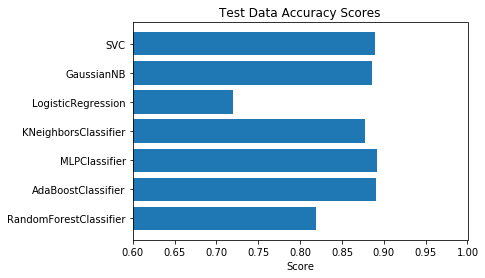

In [9]:
#Compare models' scores
def plot_test_result(clfs, test_score):
    names = []
    for i in range(0, len(clfs)): 
        clf = clfs[i]
        clf_name = clf.__class__.__name__
        names.append(clf_name)

    y_pos = np.arange(len(names))

    plt.barh(y_pos, test_scores, align='center')
    plt.yticks(y_pos, names)
    plt.xlim(0.6, 1)
    plt.xlabel('Score')
    plt.title('Test Data Accuracy Scores')

    plt.show()
plot_test_result(clfs, test_score)

In [29]:
#Defining the best classifier
best_clf = clfs_return[np.argmax(test_scores)]
best_dm_reduce = dm_reduce_return[np.argmax(test_scores)]

print("The best classifier is {}".format(best_clf.__class__.__name__))

#Define label names and get confusion matrix values
result_label = [True, False]
y_test_pred = best_clf.predict(best_dm_reduce.transform(X_test))
cm = confusion_matrix(y_test, y_test_pred, result_label)
#cm = cm.astype('float') / cm.sum()

The best classifier is MLPClassifier


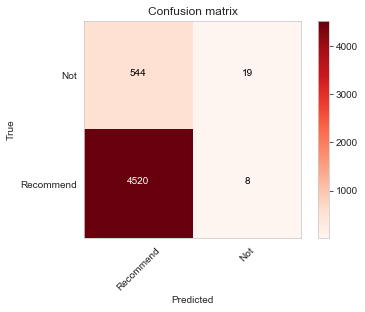

Test score of the best classifier is 0.8916
              precision    recall  f1-score   support

           0       0.70      0.03      0.06       563
           1       0.89      1.00      0.94      4528

    accuracy                           0.89      5091
   macro avg       0.80      0.52      0.50      5091
weighted avg       0.87      0.89      0.85      5091



In [30]:
# Plot confusion matrix
def plot_confusion_matrix(cm): 
    labels = ["Recommend", "Not"]
    #Configure figure
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Reds) 
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #plt.tight_layout()
    plt.xlim(-0.5,1.5)
    plt.ylim(-0.5,1.5)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    
    plt.show()
    
plot_confusion_matrix(cm)
print("Test score of the best classifier is {:.4f}".format(np.max(test_scores)))
print(classification_report(y_test, y_test_pred))

In [12]:
#Prepare predict data for user profile
user_profile_pred = pd.read_sql( \
    'select australian_users_items.user_id, australian_users_items.items_count, count(australian_user_reviews.review) as u_reviews_count, sum(australian_users_items.playtime_2weeks) as u_playtime_2weeks, sum(australian_users_items.playtime_forever) as u_playtime_forever \
        from australian_users_items \
            left join australian_user_reviews on australian_users_items.user_id=australian_user_reviews.user_id and australian_users_items.item_id=australian_user_reviews.item_id \
        group by australian_users_items.user_id;' \
    , conn)


In [13]:
#Prepare predict data for item profile
item_profile_pred = pd.read_sql( \
    'select steam_games.id, steam_games.metascore, steam_games.price, \
       accounting as accounting, action as action, adventure as adventure, "animation &amp; modeling" as aandm, "audio production" as audio_production, casual as casual, "design &amp; illustration" as dandi, "early access" as early_access, education as education, "free to play" as free_to_play, indie as indie, "massively multiplayer" as massively_multiplayer, "Photo Editing" as photo_editing, rpg as rpg, racing as racing, simulation as simulation, "software training" as software_training, sports as sports, strategy as strategy, utilities as utilities, "video production" as video_production, "web publishing" as web_publishing \
       from steam_games \
           left join item_genres on item_genres.id=steam_games.id \
        group by steam_games.id' \
    , conn)

In [14]:
#Get recommend by given user ID and item ID. 1 is recommend, 0 is not recommend.

def isRecommend(user_id, item_id):
    user_profile = user_profile_pred.loc[user_profile_pred['user_id'] == user_id]
    user_profile = user_profile.drop(['user_id'], axis=1)
    user_profile = user_profile.fillna(0)
    
    item_profile = item_profile_pred.loc[item_profile_pred['id'] == item_id]
    item_profile = item_profile.drop(['id'], axis=1)
    item_profile = item_profile.fillna(0)
    
    user_item_profile_pred = pd.concat([user_profile.iloc[[0]], item_profile.iloc[[0]]], axis=1)

    pred = np.concatenate((user_profile.iloc[[0]].to_numpy(), item_profile.iloc[[0]].to_numpy()), axis=1)
    
    pred = transformer.transform(pred)
    
    is_recommend = best_clf.predict(best_dm_reduce.transform(pred))
                                     
    return is_recommend
    
print(isRecommend('76561198141443390','413120'))

[1]
